In [25]:
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import cv2
import numpy as np
import pandas as pd
from PIL import Image

def apply_adaptive_threshold(img):
    gray_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    th_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return Image.fromarray(th_img)


transform = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.Lambda(apply_adaptive_threshold),  
    transforms.ToTensor()  
])
data = ImageFolder(root="./add_data", transform=transform) # 데이터를 추가하였음
data2 = ImageFolder(root="./data_test", transform=transform)

In [26]:
data_loader = DataLoader(data, batch_size=10, shuffle=True)
test_loader = DataLoader(data2, batch_size=7, shuffle=True)

In [27]:
images, labels = next(iter(data_loader))
print(images.shape, labels.shape)

torch.Size([10, 1, 50, 50]) torch.Size([10])


In [28]:
class Mob_Dog(nn.Module):
    def __init__(self):
        super(Mob_Dog, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout = nn.Dropout(p=0.5)  # Dropout 추가
        self.batchnorm1 = nn.BatchNorm2d(6)  # Batch Normalization 추가
        self.batchnorm2 = nn.BatchNorm2d(16)  # Batch Normalization 추가
        self.batchnorm3 = nn.BatchNorm1d(120)  # Batch Normalization 추가
        self.batchnorm4 = nn.BatchNorm1d(84)  # Batch Normalization 추가
        
    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))  # Batch Normalization 추가
        
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.batchnorm3(self.fc1(x)))  # Batch Normalization 추가
        x = F.relu(self.batchnorm4(self.fc2(x)))  # Batch Normalization 추가
        x = self.dropout(x)  # Dropout 추가
        x = self.fc3(x)
        return x


In [29]:
# 모델 객체 생성, 옵티마이저 생성
model = Mob_Dog()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [30]:
def get_accuracy(loader, model):
    total=0
    correct=0
    for data in loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

In [31]:
from tqdm import tqdm # 프로그레스 바 생성
from torch.optim.lr_scheduler import ReduceLROnPlateau 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, verbose=True)

loss_list=[]
tas_list=[]
tes_list=[]
max=0
for epoch in range(100): # 10회 반복 
    running_loss = 0.0 # 1 epoch당 누적 로스값 
    #==================================================================================
    pbar = tqdm(enumerate(data_loader), total=len(data_loader)) 
    for i, data in pbar: # pbar가 데이터 로더 역할 수행
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # 로스 누적 
        if i % 10 == 9:
            pbar.set_description(f'Epoch [{epoch + 1}/{10}], 횟수 [{i + 1}/{len(data_loader)}], Loss: {running_loss / 10:.4f}')
            loss_list.append(running_loss)
            running_loss = 0.0
    #==================================================================================   
    # 모델 평가

    with torch.no_grad():
        train_accuracy = get_accuracy(data_loader, model)
        test_accuracy = get_accuracy(test_loader, model)
    print(f'{epoch} Epoch 종료 후 train_score : {(100 * train_accuracy)}')
    print(f'{epoch} Epoch 종료 후 test_score : {(100 * test_accuracy)}')
    tas_list.append(train_accuracy)
    tes_list.append(test_accuracy)
    if max < test_accuracy:
        max = test_accuracy
        torch.save(model.state_dict(), 'model.pth')
    
    scheduler.step(loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Early Stopping at : {epoch} Epoch")
        break

Epoch [1/10], 횟수 [40/44], Loss: 0.6001: 100%|██████████| 44/44 [00:01<00:00, 41.08it/s]


0 Epoch 종료 후 train_score : 84.75750577367207
0 Epoch 종료 후 test_score : 75.30864197530865


Epoch [2/10], 횟수 [40/44], Loss: 0.2851: 100%|██████████| 44/44 [00:00<00:00, 46.52it/s]


1 Epoch 종료 후 train_score : 92.60969976905312
1 Epoch 종료 후 test_score : 70.37037037037037


Epoch [3/10], 횟수 [40/44], Loss: 0.2180: 100%|██████████| 44/44 [00:00<00:00, 45.88it/s]


2 Epoch 종료 후 train_score : 95.61200923787528
2 Epoch 종료 후 test_score : 71.60493827160494


Epoch [4/10], 횟수 [40/44], Loss: 0.1279: 100%|██████████| 44/44 [00:00<00:00, 47.39it/s]


3 Epoch 종료 후 train_score : 96.76674364896074
3 Epoch 종료 후 test_score : 70.37037037037037


Epoch [5/10], 횟수 [40/44], Loss: 0.0792: 100%|██████████| 44/44 [00:00<00:00, 47.03it/s]


4 Epoch 종료 후 train_score : 97.22863741339492
4 Epoch 종료 후 test_score : 66.66666666666666


Epoch [6/10], 횟수 [40/44], Loss: 0.1317: 100%|██████████| 44/44 [00:00<00:00, 48.09it/s]


5 Epoch 종료 후 train_score : 97.45958429561202
5 Epoch 종료 후 test_score : 67.90123456790124


Epoch [7/10], 횟수 [40/44], Loss: 0.0681: 100%|██████████| 44/44 [00:00<00:00, 46.84it/s]


6 Epoch 종료 후 train_score : 98.61431870669746
6 Epoch 종료 후 test_score : 69.1358024691358


Epoch [8/10], 횟수 [40/44], Loss: 0.1646: 100%|██████████| 44/44 [00:00<00:00, 47.50it/s]


7 Epoch 종료 후 train_score : 95.1501154734411
7 Epoch 종료 후 test_score : 62.96296296296296


Epoch [9/10], 횟수 [40/44], Loss: 0.0774: 100%|██████████| 44/44 [00:00<00:00, 44.79it/s]


8 Epoch 종료 후 train_score : 96.07390300230946
8 Epoch 종료 후 test_score : 64.19753086419753


Epoch [10/10], 횟수 [40/44], Loss: 0.0379: 100%|██████████| 44/44 [00:00<00:00, 46.83it/s]


9 Epoch 종료 후 train_score : 99.30715935334872
9 Epoch 종료 후 test_score : 64.19753086419753


Epoch [11/10], 횟수 [40/44], Loss: 0.0356: 100%|██████████| 44/44 [00:00<00:00, 46.82it/s]


10 Epoch 종료 후 train_score : 99.07621247113164
10 Epoch 종료 후 test_score : 62.96296296296296


Epoch [12/10], 횟수 [40/44], Loss: 0.1366: 100%|██████████| 44/44 [00:00<00:00, 46.00it/s]


11 Epoch 종료 후 train_score : 97.22863741339492
11 Epoch 종료 후 test_score : 64.19753086419753


Epoch [13/10], 횟수 [40/44], Loss: 0.0977: 100%|██████████| 44/44 [00:00<00:00, 45.52it/s]


12 Epoch 종료 후 train_score : 96.07390300230946
12 Epoch 종료 후 test_score : 64.19753086419753


Epoch [14/10], 횟수 [40/44], Loss: 0.0827: 100%|██████████| 44/44 [00:01<00:00, 40.25it/s]


13 Epoch 종료 후 train_score : 96.99769053117782
13 Epoch 종료 후 test_score : 71.60493827160494


Epoch [15/10], 횟수 [40/44], Loss: 0.0953: 100%|██████████| 44/44 [00:00<00:00, 46.93it/s]


14 Epoch 종료 후 train_score : 98.61431870669746
14 Epoch 종료 후 test_score : 69.1358024691358


Epoch [16/10], 횟수 [40/44], Loss: 0.0490: 100%|██████████| 44/44 [00:00<00:00, 47.14it/s]


15 Epoch 종료 후 train_score : 97.6905311778291
15 Epoch 종료 후 test_score : 61.72839506172839


Epoch [17/10], 횟수 [40/44], Loss: 0.0985: 100%|██████████| 44/44 [00:00<00:00, 48.07it/s]


16 Epoch 종료 후 train_score : 99.76905311778292
16 Epoch 종료 후 test_score : 70.37037037037037


Epoch [18/10], 횟수 [40/44], Loss: 0.0342: 100%|██████████| 44/44 [00:00<00:00, 46.70it/s]


17 Epoch 종료 후 train_score : 98.38337182448036
17 Epoch 종료 후 test_score : 66.66666666666666


Epoch [19/10], 횟수 [40/44], Loss: 0.2056: 100%|██████████| 44/44 [00:00<00:00, 45.02it/s]


18 Epoch 종료 후 train_score : 97.45958429561202
18 Epoch 종료 후 test_score : 65.4320987654321


Epoch [20/10], 횟수 [40/44], Loss: 0.0141: 100%|██████████| 44/44 [00:01<00:00, 43.94it/s]


19 Epoch 종료 후 train_score : 99.30715935334872
19 Epoch 종료 후 test_score : 70.37037037037037


Epoch [21/10], 횟수 [40/44], Loss: 0.0765: 100%|██████████| 44/44 [00:01<00:00, 43.15it/s]


20 Epoch 종료 후 train_score : 98.38337182448036
20 Epoch 종료 후 test_score : 67.90123456790124


Epoch [22/10], 횟수 [40/44], Loss: 0.0886: 100%|██████████| 44/44 [00:01<00:00, 40.26it/s]


21 Epoch 종료 후 train_score : 98.38337182448036
21 Epoch 종료 후 test_score : 65.4320987654321


Epoch [23/10], 횟수 [40/44], Loss: 0.0581: 100%|██████████| 44/44 [00:01<00:00, 38.49it/s]


22 Epoch 종료 후 train_score : 99.07621247113164
22 Epoch 종료 후 test_score : 65.4320987654321


Epoch [24/10], 횟수 [40/44], Loss: 0.0326: 100%|██████████| 44/44 [00:01<00:00, 41.99it/s]


23 Epoch 종료 후 train_score : 98.61431870669746
23 Epoch 종료 후 test_score : 62.96296296296296


Epoch [25/10], 횟수 [40/44], Loss: 0.0150: 100%|██████████| 44/44 [00:01<00:00, 42.18it/s]


24 Epoch 종료 후 train_score : 97.92147806004618
24 Epoch 종료 후 test_score : 56.79012345679012


Epoch [26/10], 횟수 [40/44], Loss: 0.0225: 100%|██████████| 44/44 [00:01<00:00, 41.37it/s]


25 Epoch 종료 후 train_score : 98.38337182448036
25 Epoch 종료 후 test_score : 67.90123456790124


Epoch [27/10], 횟수 [40/44], Loss: 0.0701: 100%|██████████| 44/44 [00:01<00:00, 33.86it/s]


26 Epoch 종료 후 train_score : 99.07621247113164
26 Epoch 종료 후 test_score : 62.96296296296296


Epoch [28/10], 횟수 [40/44], Loss: 0.0623: 100%|██████████| 44/44 [00:01<00:00, 43.36it/s]


27 Epoch 종료 후 train_score : 98.38337182448036
27 Epoch 종료 후 test_score : 69.1358024691358


Epoch [29/10], 횟수 [40/44], Loss: 0.0662: 100%|██████████| 44/44 [00:01<00:00, 42.53it/s]


28 Epoch 종료 후 train_score : 99.30715935334872
28 Epoch 종료 후 test_score : 66.66666666666666


Epoch [30/10], 횟수 [40/44], Loss: 0.0929: 100%|██████████| 44/44 [00:01<00:00, 41.73it/s]


29 Epoch 종료 후 train_score : 99.07621247113164
29 Epoch 종료 후 test_score : 66.66666666666666


Epoch [31/10], 횟수 [40/44], Loss: 0.0376: 100%|██████████| 44/44 [00:01<00:00, 34.77it/s]


<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

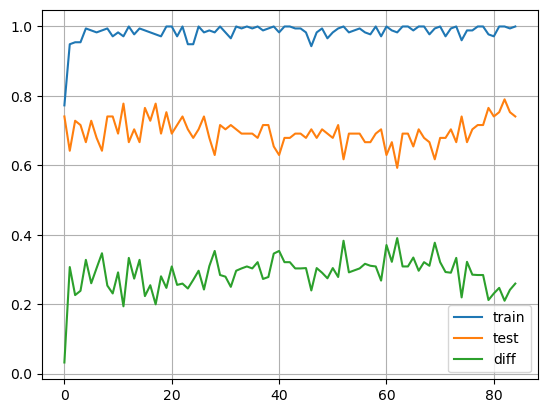

In [ ]:
import matplotlib.pyplot as plt

#plt.plot(loss_list)
plt.plot(tas_list, label="train")
plt.plot(tes_list, label="test")
plt.plot(np.array(tas_list)-np.array(tes_list), label="diff")
plt.grid(True)
plt.legend()
plt.ylabel

In [ ]:
# 확실히 높아진 성능을 자랑한다....

In [ ]:
model = Mob_Dog()
model.load_state_dict(torch.load('model.pth'))
model.eval()

# 이미지 예측
img = cv2.imread('./data/mop_dog/74.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (50, 50))
img = img / 255.0
img = torch.Tensor(img)
img = img.unsqueeze(0).unsqueeze(1)

with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output.data, 1)
predicted, output # 예측도 슬슬,,,잘 나온다!

(tensor([1]), tensor([[-0.5451,  0.5950]]))

In [ ]:
# 추가적으로 데이터셋을 늘려보고, 정규화와 이퀄라이즈, Clahe를 사용해보자! 